In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
import datetime
import time

from tensorflow import keras
from tensorflow.keras import Model,losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Activation, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dropout, Add, MaxPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras import datasets, layers, models, losses

#All the sklearn libraries CNN
from sklearn import metrics
from sklearn.metrics import precision_score , recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [7]:
print(tf.__version__)

2.10.0


In [8]:
(x_train,y_train),(x_test,y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 2s 0us/step


In [9]:
print('The number of images in training dataset is',x_train.shape[0])
print('The number of images in training dataset is',x_test.shape[0])

The number of images in training dataset is 60000
The number of images in training dataset is 10000


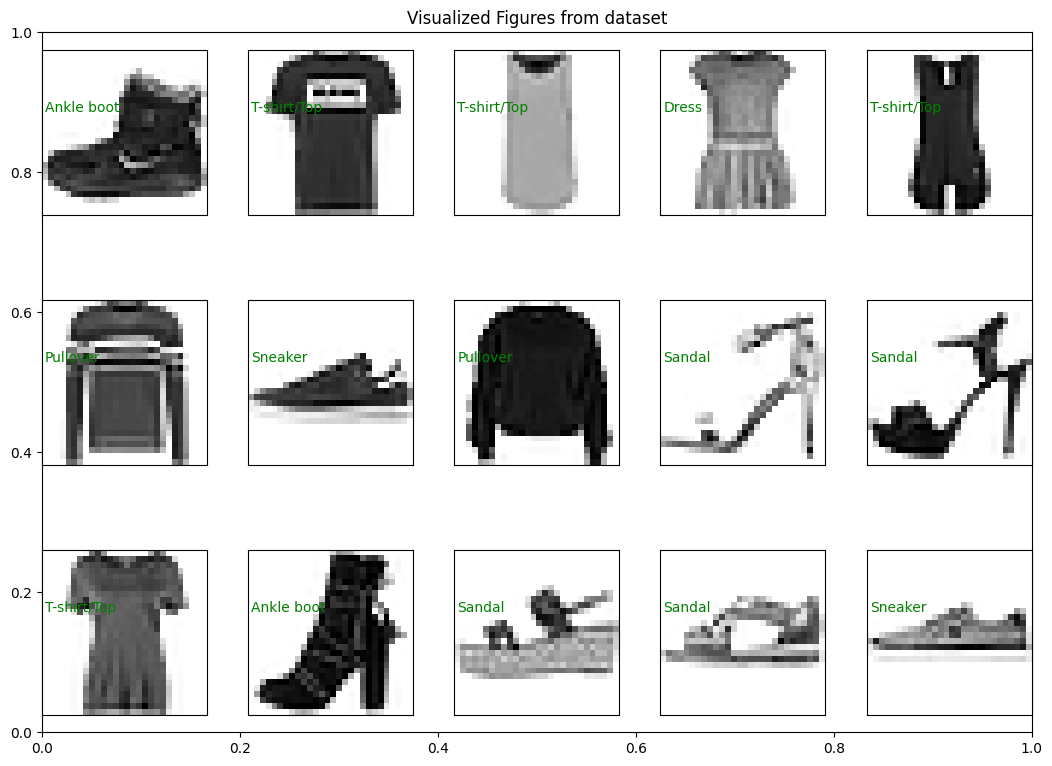

In [10]:
class_names = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig = plt.figure(figsize=(11, 7))
fig.subplots_adjust(left=0, bottom=0, top=1, hspace=0.25, wspace=0.25)
plt.title('Visualized Figures from dataset')
for i in range(15):
  ax = fig.add_subplot(3, 5, i + 1, xticks=[],yticks=[])
  ax.imshow(x_train[i],cmap=plt.cm.gray_r, interpolation='nearest')
  ax.text(0, 10, class_names[y_train[i]], color='green')

In [11]:
print('The image shape is', x_train[0].shape, 'for training dataset')
print('The image shape is', x_test[0].shape, 'for testing dataset')

The image shape is (28, 28) for training dataset
The image shape is (28, 28) for testing dataset


In [12]:
x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]

In [13]:
print('The new image shape is', x_train[0].shape, 'for training dataset')
print('The new image shape is', x_test[0].shape, 'for testing dataset')

The new image shape is (28, 28, 1) for training dataset
The new image shape is (28, 28, 1) for testing dataset


In [14]:
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [15]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/255
x_test = x_test/255
image_shape=(28,28,1)

In [16]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback =tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [17]:
class ResidualBlock(Model):
    def __init__(self, channel_in = 64, channel_out = 256):
        super().__init__()
        
        channel = channel_out // 4
        
        self.conv1 = Conv2D(channel, kernel_size = (1, 1), padding = "same")
        self.bn1 = BatchNormalization()
        self.av1 = Activation(tf.nn.relu)
        self.conv2 = Conv2D(channel, kernel_size = (3, 3), padding = "same")
        self.bn2 = BatchNormalization()
        self.av2 = Activation(tf.nn.relu)
        self.conv3 = Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
        self.bn3 = BatchNormalization()
        self.shortcut = self._shortcut(channel_in, channel_out)
        self.add = Add()
        self.av3 = Activation(tf.nn.relu)
        
    def call(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.av1(h)
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.av2(h)
        h = self.conv3(h)
        h = self.bn3(h)
        shortcut = self.shortcut(x)
        h = self.add([h, shortcut])
        y = self.av3(h)
        return y
    
    def _shortcut(self, channel_in, channel_out):
        if channel_in == channel_out:
            return lambda x : x
        else:
            return self._projection(channel_out)
        
    def _projection(self, channel_out):
        return Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
           
class ResNet50(Model):
    def __init__(self, input_shape, output_dim):
        super().__init__()                
        
        self._layers = [
            # conv1
            Conv2D(64, input_shape = input_shape, kernel_size = (7, 7), strides=(2, 2), padding = "same"),
            BatchNormalization(),
            Activation(tf.nn.relu),
            # conv2_x
            MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same"),
            ResidualBlock(64, 256),
            [
                ResidualBlock(256, 256) for _ in range(2)                
            ],
            # conv3_x
            Conv2D(512, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(512, 512) for _ in range(4)                
            ],
            # conv4_x
            Conv2D(1024, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(1024, 1024) for _ in range(6)                
            ],
            # conv5_x
            Conv2D(2048, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(2048, 2048) for _ in range(3)
            ],
            # last part
            GlobalAveragePooling2D(),
            Dense(1000, activation = tf.nn.relu),
            Dense(output_dim, activation = tf.nn.softmax)
        ]
        
    def call(self, x):
        for layer in self._layers:
            if isinstance(layer, list):
                for l in layer:
                    x = l(x)    
            else:
                x = layer(x)
        return x
       
    
ResNet50_model = ResNet50((28, 28, 1), 10)
ResNet50_model.build(input_shape = (None, 28, 28, 1))

In [18]:
ResNet50_model.summary()

Model: "res_net50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 residual_block (ResidualBlo  multiple                 75904     
 ck)                                                             
                                                         

In [19]:
ResNet50_model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [20]:
start_time = time.time()

ResNet = ResNet50_model.fit(x_train, y_train, batch_size=64, 
                    epochs=20, validation_data=(x_test, y_test),callbacks=[tensorboard_callback],verbose=1)

end_time = time.time() 
resNet_run_time = end_time - start_time
print('ResNet-50 run Time is: ',resNet_run_time,'seconds')

Epoch 1/20
938/938 [==============================] - 35s 31ms/step - loss: 0.6761 - accuracy: 0.7841 - val_loss: 0.5077 - val_accuracy: 0.8173
Epoch 2/20
938/938 [==============================] - 28s 29ms/step - loss: 0.3826 - accuracy: 0.8627 - val_loss: 0.3830 - val_accuracy: 0.8643
Epoch 3/20
938/938 [==============================] - 28s 29ms/step - loss: 0.3657 - accuracy: 0.8695 - val_loss: 0.3461 - val_accuracy: 0.8759
Epoch 4/20
938/938 [==============================] - 29s 30ms/step - loss: 0.3153 - accuracy: 0.8878 - val_loss: 0.3836 - val_accuracy: 0.8694
Epoch 5/20
938/938 [==============================] - 28s 30ms/step - loss: 0.3339 - accuracy: 0.8840 - val_loss: 0.4039 - val_accuracy: 0.8477
Epoch 6/20
938/938 [==============================] - 29s 30ms/step - loss: 0.3027 - accuracy: 0.8937 - val_loss: 0.4531 - val_accuracy: 0.8552
Epoch 7/20
938/938 [==============================] - 28s 30ms/step - loss: 0.2722 - accuracy: 0.9021 - val_loss: 0.2859 - val_accuracy:

In [21]:
ResNet50_model.evaluate(x_test,y=y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.2903 - accuracy: 0.9061


[0.2902604043483734, 0.9060999751091003]

313/313 [==============================] - 2s 4ms/step


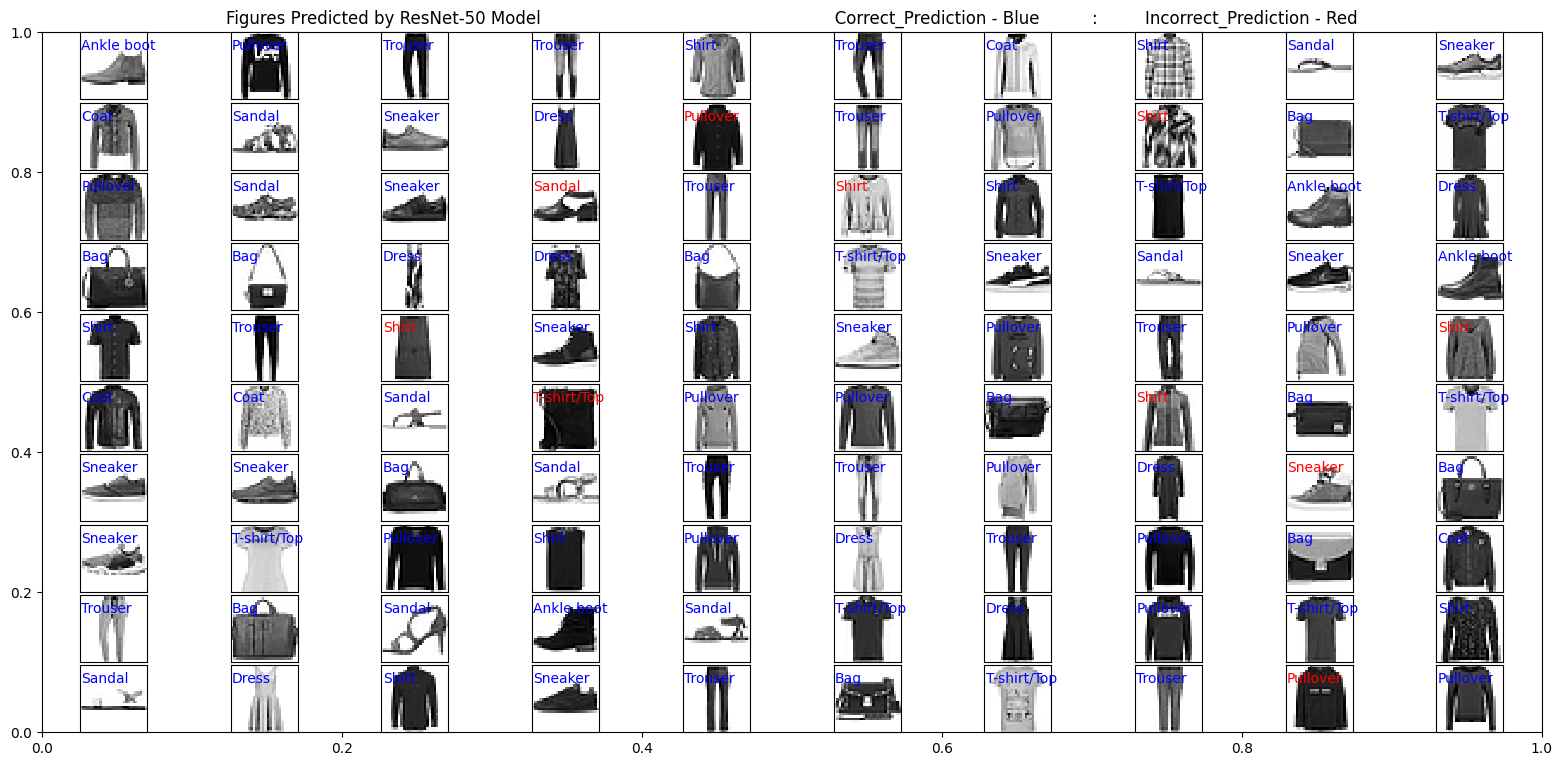

In [22]:
resNet_prediction_val = ResNet50_model.predict(x_test)
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
plt.title('Figures Predicted by ResNet-50 Model                                                        Correct_Prediction - Blue          :         Incorrect_Prediction - Red')
for i in range(100):
  ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
  ax.imshow(x_test[i,:].reshape((28,28)),cmap=plt.cm.gray_r, interpolation='nearest')
  
  if np.argmax(resNet_prediction_val[i]) == np.argmax(y_test[i]):
    ax.text(0, 7, class_names[np.argmax(resNet_prediction_val[i])], color='blue')
  else:
    ax.text(0, 7, class_names[np.argmax(resNet_prediction_val[i])], color='red')

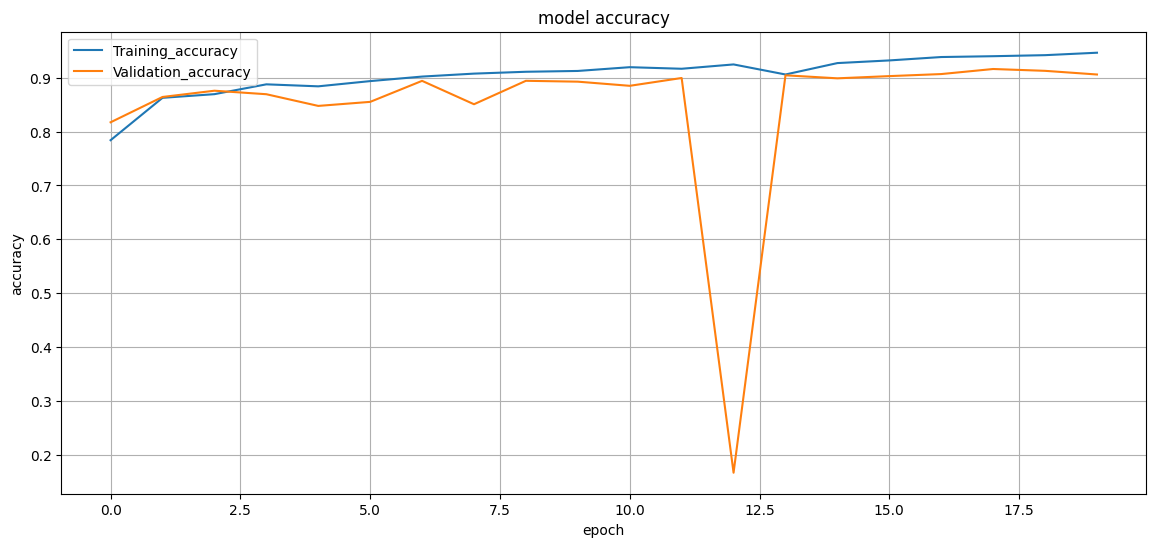

In [23]:
plt.figure(figsize=(14,6))
plt.plot(ResNet.history['accuracy'])
plt.plot(ResNet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['Training_accuracy', 'Validation_accuracy'], loc='upper left')
plt.show()

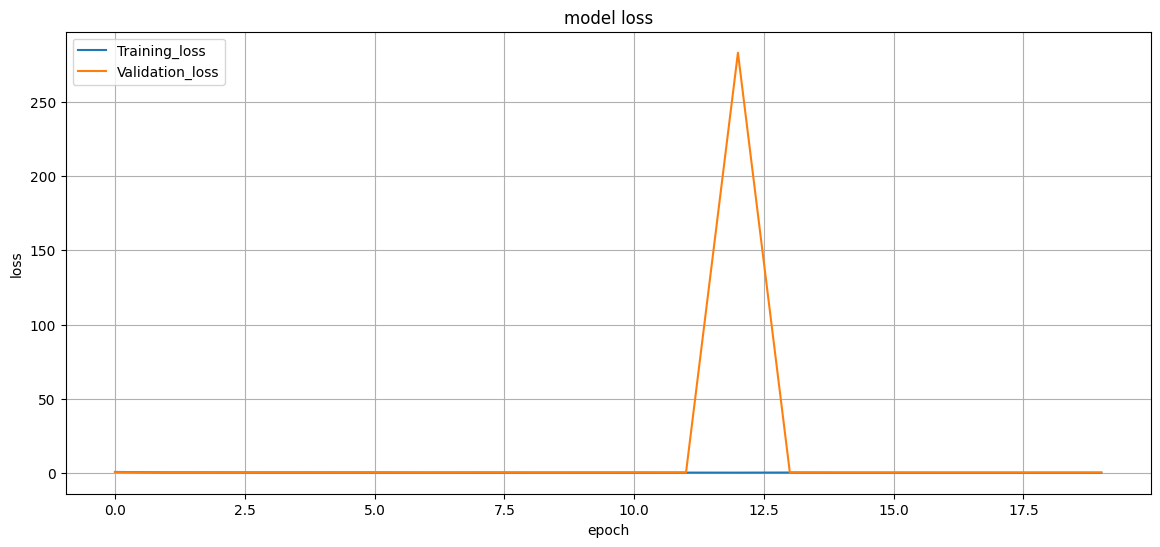

In [24]:
plt.figure(figsize=(14,6))
plt.plot(ResNet.history['loss'])
plt.plot(ResNet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['Training_loss', 'Validation_loss'], loc='upper left')
plt.show()